### 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows (맑은 고딕)
# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor

In [2]:
# train, test 데이터를 불러옵니다.
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

### EDA

In [3]:
train# 데이터 크기 확인
print("📌 Train 데이터 크기:", train.shape)
print("📌 Test 데이터 크기:", test.shape)

# 컬럼별 결측치 개수 확인
print("\n📌 결측치 개수:")
print(train.isnull().sum())

# 기본 통계량 출력
print("\n📌 연속형 변수 기본 통계량:")
print(train.describe())

📌 Train 데이터 크기: (7497, 11)
📌 Test 데이터 크기: (846, 10)

📌 결측치 개수:
ID             0
제조사            0
모델             0
차량상태           0
배터리용량       2711
구동방식           0
주행거리(km)       0
보증기간(년)        0
사고이력           0
연식(년)          0
가격(백만원)        0
dtype: int64

📌 연속형 변수 기본 통계량:
             배터리용량       주행거리(km)      보증기간(년)        연식(년)      가격(백만원)
count  4786.000000    7497.000000  7497.000000  7497.000000  7497.000000
mean     69.397187   44287.979458     4.960918     0.222489    62.331949
std      15.283635   55204.064386     3.155342     0.569232    36.646759
min      46.000000       3.000000     0.000000     0.000000     9.000000
25%      56.359000    5465.000000     2.000000     0.000000    34.390000
50%      68.125000   17331.000000     5.000000     0.000000    56.000000
75%      78.227000   61252.000000     8.000000     0.000000    80.050000
max      99.800000  199827.000000    10.000000     2.000000   161.090000


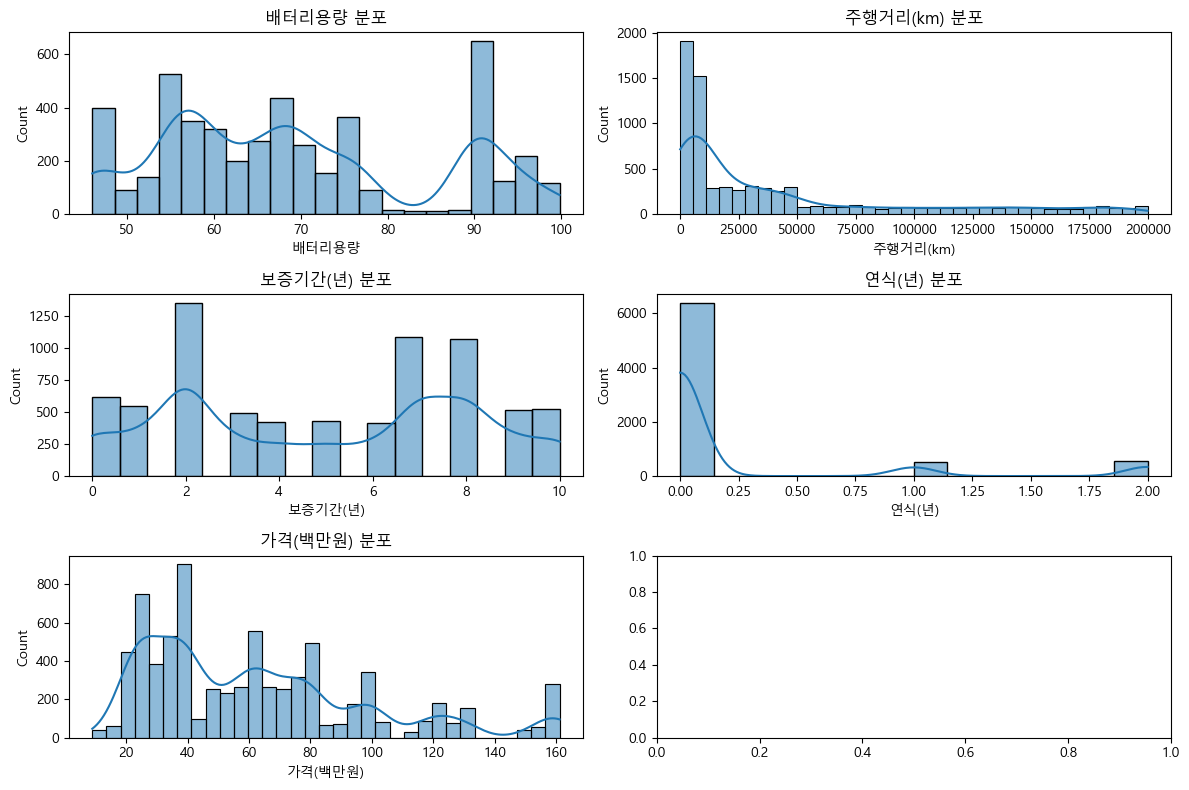

In [4]:
## 히스토그램

# 연속형 변수 리스트
numeric_features = ["배터리용량", "주행거리(km)", "보증기간(년)", "연식(년)", "가격(백만원)"]

# 히스토그램 출력
def plot_histograms(data, columns, cols=2, figsize=(12, 8)):
    rows = (len(columns) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.histplot(data[col], kde=True, ax=axes[i])
        axes[i].set_title(f"{col} 분포")

    plt.tight_layout()
    plt.show()

# 실행
plot_histograms(train, numeric_features)


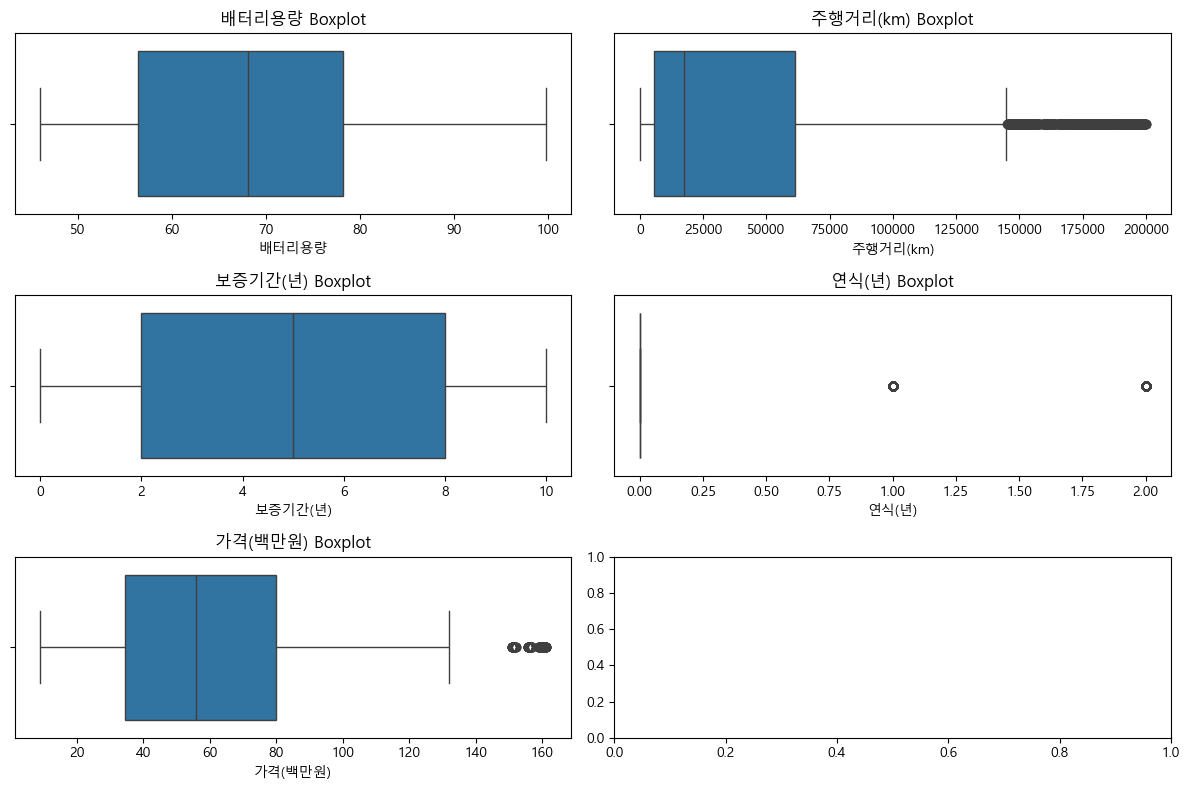

In [5]:
# 박스플롯 출력 함수
def plot_boxplots(data, columns, cols=2, figsize=(12, 8)):
    rows = (len(columns) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.boxplot(x=data[col], ax=axes[i])
        axes[i].set_title(f"{col} Boxplot")

    plt.tight_layout()
    plt.show()

# 실행
plot_boxplots(train, numeric_features)


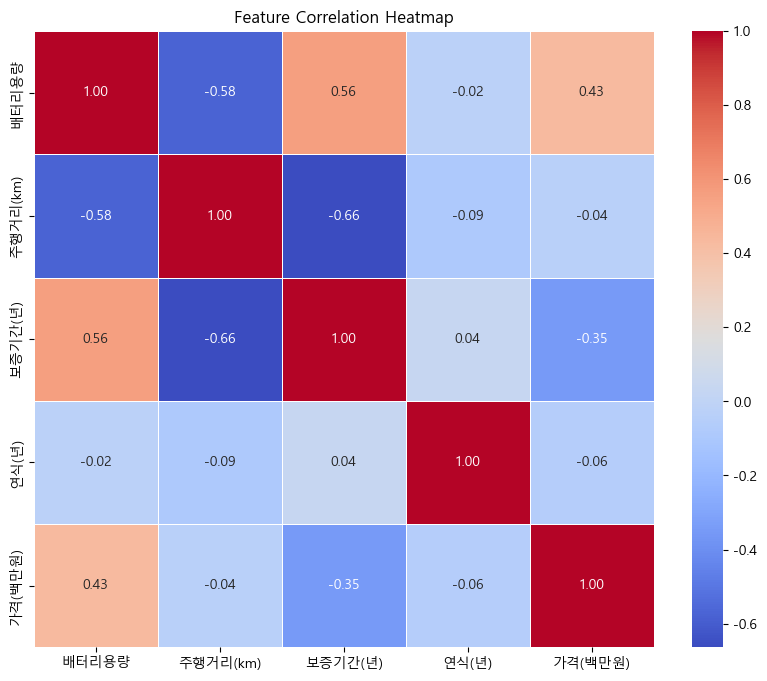

In [6]:
# 상관관계 히트맵 출력 (숫자형 변수만 선택)
def plot_correlation_heatmap(data):
    numeric_data = data.select_dtypes(include=["number"])  # 숫자형 변수만 선택
    plt.figure(figsize=(10, 8))
    sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Feature Correlation Heatmap")
    plt.show()

# 실행
plot_correlation_heatmap(train)


## Data Preprocessing

In [7]:
# 📌 1. 결측치 처리 (배터리용량 → 모델별 평균값으로 대체)
battery_fill_values = train.groupby("모델")["배터리용량"].mean()
train["배터리용량"] = train.apply(lambda row: battery_fill_values[row["모델"]] if pd.isnull(row["배터리용량"]) else row["배터리용량"], axis=1)
test["배터리용량"] = test.apply(lambda row: battery_fill_values[row["모델"]] if pd.isnull(row["배터리용량"]) else row["배터리용량"], axis=1)

# 전체 평균값으로 최종 대체
train["배터리용량"].fillna(train["배터리용량"].mean(), inplace=True)
test["배터리용량"].fillna(train["배터리용량"].mean(), inplace=True)


In [8]:
# 📌 2. 이상치 처리 (주행거리 → IQR 기반 제거 + 로그 변환)
Q1 = train["주행거리(km)"].quantile(0.25)
Q3 = train["주행거리(km)"].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

# 이상치 제거
train = train[train["주행거리(km)"] <= upper_bound]

# 로그 변환 적용
train["주행거리(km)"] = np.log1p(train["주행거리(km)"])
test["주행거리(km)"] = np.log1p(test["주행거리(km)"])

In [9]:
# 📌 3. 범주형 변수 변환 (Label Encoding + One-Hot Encoding)
categorical_columns = ["제조사", "모델", "차량상태", "구동방식"]
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])
    label_encoders[col] = le

# 사고이력 (Yes/No) → One-Hot Encoding
train = pd.get_dummies(train, columns=["사고이력"], drop_first=True)
test = pd.get_dummies(test, columns=["사고이력"], drop_first=True)

In [10]:
# 📌 4. 수치형 변수 스케일링 (StandardScaler 적용)
scaler = StandardScaler()
num_features = ["배터리용량", "주행거리(km)", "보증기간(년)", "연식(년)"]
train[num_features] = scaler.fit_transform(train[num_features])
test[num_features] = scaler.transform(test[num_features])

In [11]:
# 📌 5. 전처리된 데이터 저장
train.to_csv("processed_train.csv", index=False)
test.to_csv("processed_test.csv", index=False)

print("✅ 전처리 완료! 데이터가 processed_train.csv 및 processed_test.csv로 저장되었습니다.")

✅ 전처리 완료! 데이터가 processed_train.csv 및 processed_test.csv로 저장되었습니다.
